In [94]:
import sys
!conda install --yes --prefix {sys.prefix} scikit-image
!pip install matplotlib

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.1
  latest version: 4.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

You should consider upgrading via the '/anaconda3/bin/python -m pip install --upgrade pip' command.


In [95]:
import skimage
import skimage.feature
import skimage.viewer
import sys
import matplotlib.pyplot as plt
from skimage import filters
from skimage.filters import threshold_mean
from skimage.filters import threshold_minimum

filename = 'images.jpeg'
#filename = 'axeillus.jpg'

# load and display original image as grayscale
image = skimage.io.imread(fname=filename, as_gray=True)


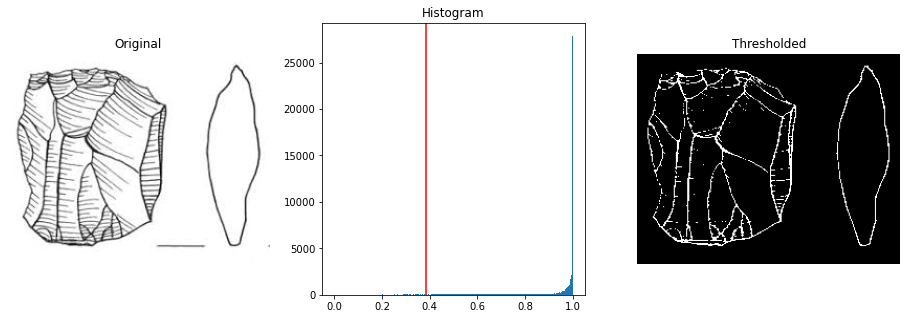

In [228]:
thresh = threshold_minimum(image)
#thresh = threshold_mean(image)

binary = image < thresh + thresh*0.2
#binary = image < thresh 

fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

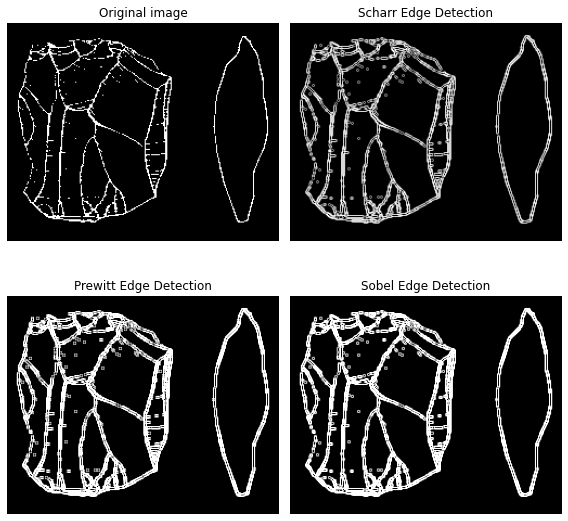

In [229]:
from skimage.util import compare_images
import numpy as np
# Creating a rotation-invariant image with different spatial frequencies.
image_rot = binary

edge_sobel = filters.sobel(image_rot)
edge_scharr = filters.scharr(image_rot)
edge_prewitt = filters.prewitt(image_rot)



fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(8, 8))
axes = axes.ravel()

axes[0].imshow(image_rot, cmap=plt.cm.gray)
axes[0].set_title('Original image')

axes[1].imshow(edge_scharr, cmap=plt.cm.gray)
axes[1].set_title('Scharr Edge Detection')

axes[2].imshow(edge_prewitt, cmap=plt.cm.gray, vmax=max_diff)
axes[2].set_title('Prewitt Edge Detection')

axes[3].imshow(edge_sobel, cmap=plt.cm.gray, vmax=max_diff)
axes[3].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

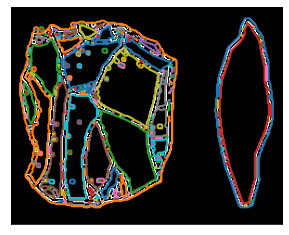

In [230]:
# Find contours at a constant value of 0.8
contours = measure.find_contours(edge_sobel, 0.1,fully_connected='low')

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(edges2, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [231]:
new_countours = []
for cont in contours:
    if cont.shape[0]<80:
        continue
    else:
        new_countours.append(cont)
        
new_countours = np.array(new_countours)

/anaconda3/envs/vivarium_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


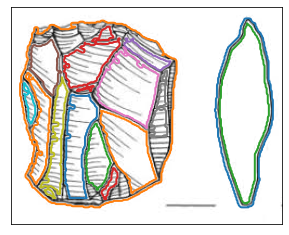

In [232]:
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for contour in new_countours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [233]:
len(new_countours)

14

In [234]:
import scipy.ndimage as ndimage    

contour = new_countours[6]
#contour = new_countours[19]


# Create an empty image to store the masked array
r_mask = np.zeros_like(image, dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value
r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1

# Fill in the hole created by the contour boundary
r_mask = ndimage.binary_fill_holes(r_mask)

# Invert the mask since you want pixels outside of the region
new_image = np.multiply(r_mask,image)

new_image = new_image 

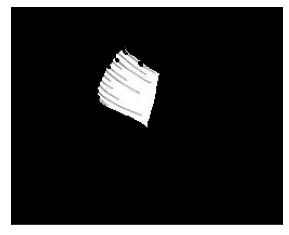

In [235]:
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(new_image, cmap=plt.cm.gray)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

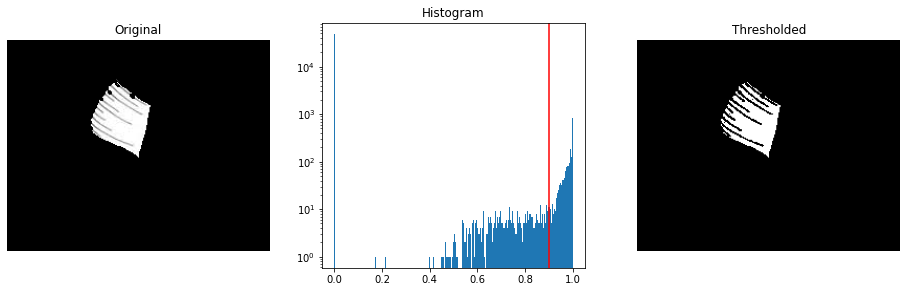

In [236]:
from skimage.filters import threshold_multiotsu

thresh = threshold_minimum(new_image)
binary_sub_image = new_image > 0.9 





fig, axes = plt.subplots(ncols=3, figsize=(16, 4.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(new_image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(new_image.ravel(), bins=256)
ax[1].set_yscale('log')
ax[1].set_title('Histogram')
ax[1].axvline(0.9, color='r')

ax[2].imshow(binary_sub_image, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()
 


/anaconda3/envs/vivarium_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Previously, sato implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.
  


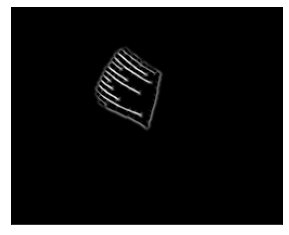

In [294]:
# Find contours at a constant value of 0.8
edge_sobel = filters.sato(binary_sub_image,sigmas=range(1, 2, 1))

   
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(binary_sub_image, cmap=plt.cm.gray)
ax.imshow(edge_sobel, cmap=plt.cm.gray)

    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

12


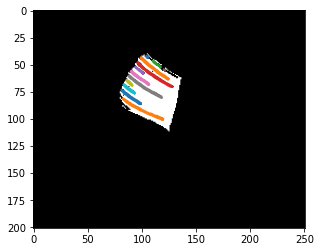

In [295]:
contours = measure.find_contours(edge_sobel, 0.19,fully_connected='high')

fig, ax = plt.subplots()
ax.imshow(binary_sub_image, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
print (len(contours))